# Importamos las librerias y los datasets

In [188]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

In [77]:
train = pd.read_csv('train_completo.csv')
test = pd.read_csv('test_completo.csv')

In [78]:
y = train['fault_severity']
train.drop(['id', 'fault_severity'], axis=1, inplace=True)
X = train

## Aplicando SMOTE a los datos para balancear las clases

Sabemos que tenemos un problema de clases desbalanceadas, se analizará el comportamiento del modelo al realizar un Oversampling, quiere decir que aumentaremos el numero de registros de la clase minoritaria a fin de balancear todas las clases

In [64]:
100*(y.value_counts()/len(y))

0.0    64.815066
1.0    25.348869
2.0     9.836066
Name: fault_severity, dtype: float64

Text(0.5, 0, 'Clases')

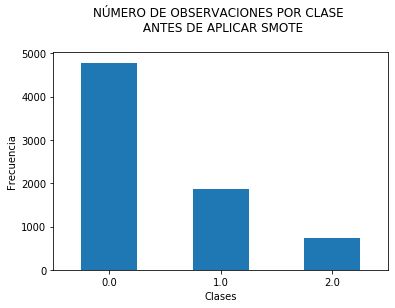

In [68]:
count_classes = pd.value_counts(y, sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title('NÚMERO DE OBSERVACIONES POR CLASE \n ANTES DE APLICAR SMOTE\n')
plt.ylabel('Frecuencia')
plt.xlabel('Clases')

In [79]:
oversampling = SMOTE()
X, y = oversampling.fit_resample(X, y)

In [71]:
100*(y.value_counts()/len(y))

2.0    33.333333
0.0    33.333333
1.0    33.333333
Name: fault_severity, dtype: float64

Text(0.5, 0, 'Clases')

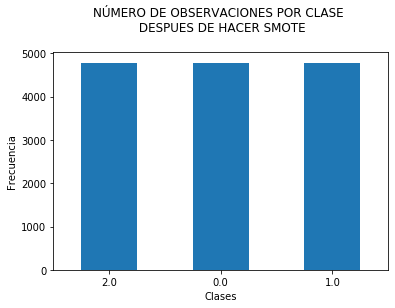

In [80]:
count_classes = pd.value_counts(y, sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title('NÚMERO DE OBSERVACIONES POR CLASE \n DESPUES DE HACER SMOTE\n')
plt.ylabel('Frecuencia')
plt.xlabel('Clases')

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_predict = model.predict_proba(X_test)
l_loss = log_loss(y_test, y_predict)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('log_loss: {}'.format(l_loss))
print('---- confusion matrix ----')
print(100*(cm/len(y_test)))

log_loss: 0.5984046498055863
---- confusion matrix ----
[[23.68512713  7.10553814  2.54266806]
 [ 4.07523511 22.88401254  7.17520028]
 [ 0.4528039   4.21455939 27.86485545]]


A pesar de que el modelo mejoro la precision para predecir fallos del tipo 2, la puntuacion en kaggle empeoró teniendo un score de 0.68.

# Mejora de GBC

Se busca mejorar el desempeño de GBG, esto se hara probando el desempeño con diferentes parametros.

In [166]:
train = pd.read_csv('train_completo.csv')
test = pd.read_csv('test_completo.csv')

In [167]:
y = train['fault_severity']
train.drop(['id', 'fault_severity'], axis=1, inplace=True)
X = train

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Variando el learnign-rate

In [169]:
def test_learning_rates(learning_rate):
    print('learning rate: {}'.format(learning_rate))
    clf = GradientBoostingClassifier(learning_rate=learning_rate)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test)
    ls = log_loss(y_test, y_predict)
    print('log-loss: {}'.format(ls))
    print('------------------------\n')

In [170]:
l_rate = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]
for lr in l_rate:
    test_learning_rates(lr)

learning rate: 1
log-loss: 0.7034670240532422
------------------------

learning rate: 0.75
log-loss: 0.622583387083051
------------------------

learning rate: 0.5
log-loss: 0.5721419039690149
------------------------

learning rate: 0.25
log-loss: 0.5676757716777626
------------------------

learning rate: 0.1
log-loss: 0.5879124994167161
------------------------

learning rate: 0.05
log-loss: 0.6090193415442884
------------------------

learning rate: 0.01
log-loss: 0.6961253047086211
------------------------



observamos que el mejor desempeño lo tenemos con un learning rate de 0.25

#### Variando los n_estimators

In [171]:
def test_n_estimators(n_estimator):
    print('n estimators: {}'.format(n_estimator))
    clf = GradientBoostingClassifier(n_estimators=n_estimator)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test)
    ls = log_loss(y_test, y_predict)
    print('log-loss: {}'.format(ls))
    print('------------------------\n')

In [172]:
n_estimator = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
for n in n_estimator:
    test_n_estimators(n)

n estimators: 100
log-loss: 0.5874288832497139
------------------------

n estimators: 200
log-loss: 0.5749444990732082
------------------------

n estimators: 300
log-loss: 0.569020587020617
------------------------

n estimators: 400
log-loss: 0.5664168917612274
------------------------

n estimators: 500
log-loss: 0.5673069386586542
------------------------

n estimators: 600
log-loss: 0.5696362159948971
------------------------

n estimators: 700
log-loss: 0.5732299258107878
------------------------

n estimators: 800
log-loss: 0.5754598974729791
------------------------

n estimators: 900
log-loss: 0.5783000572635272
------------------------

n estimators: 1000
log-loss: 0.5821094990397561
------------------------



# Selección de las caracteristicas principales 

In [243]:
classifier = GradientBoostingClassifier(learning_rate=0.3, n_estimators=400)
classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=400)

In [184]:
features_importance = classifier.feature_importances_
features = np.array(train.columns)
features_analisis = pd.DataFrame(features, columns=['features'])
features_analisis['performance'] = features_importance
features_analisis.sort_values('performance', ascending=False, inplace=True)

In [185]:
def clean_features_names(df, column_name):
    df[column_name] = df[column_name].map(lambda x: x.split('log_feature_')[-1])
    df[column_name] = df[column_name].map(lambda x: x.split('severity_type_')[-1])
    df[column_name] = df[column_name].map(lambda x: x.split('event_type_')[-1])
    df[column_name] = df[column_name].map(lambda x: x.split('resource_type_')[-1])
    return df

In [186]:
features_analisis = clean_features_names(features_analisis, 'features')
best_features = features_analisis[features_analisis['performance']>1e-3]

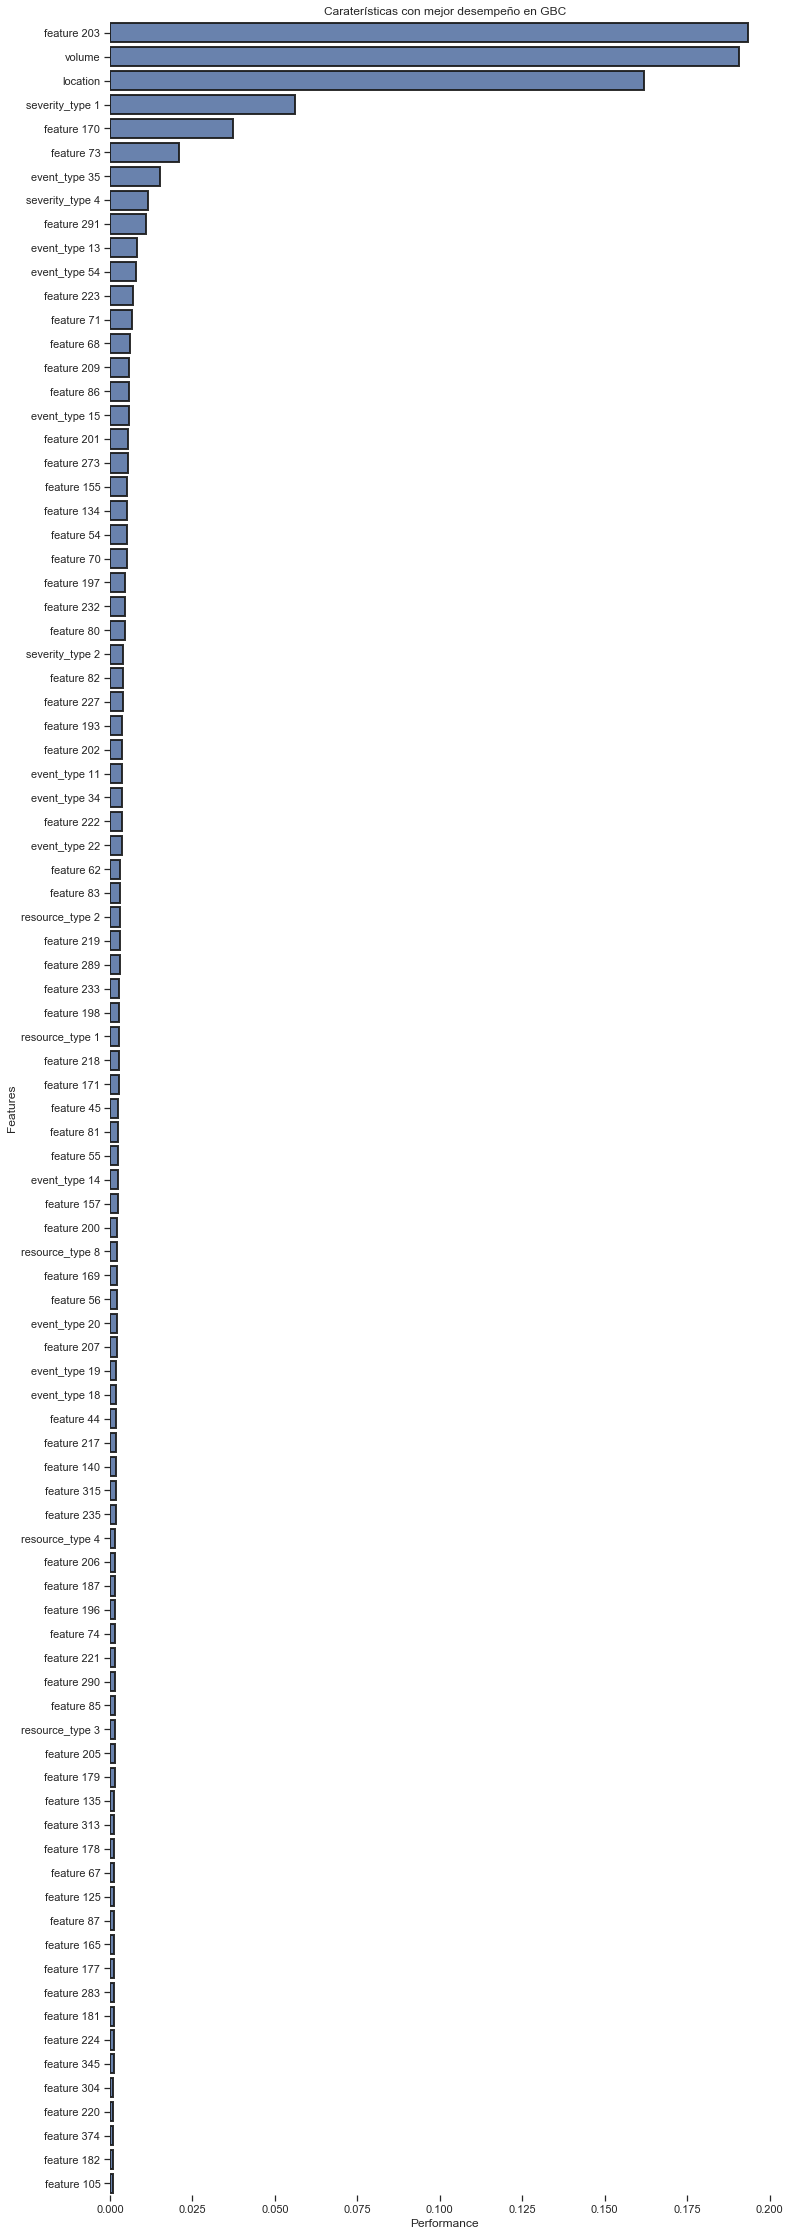

In [189]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(12, 40))

kwargs = {'alpha':0.9, 'linewidth':2, 'edgecolor':'k'}
sns.barplot(x='performance', y = "features", data=best_features,
            label="index", color="b", **kwargs)


ax.set(ylabel="Features",
       xlabel="Performance")

sns.despine(left=True, bottom=True)

ax.set_title('Caraterísticas con mejor desempeño en GBC')
f.savefig('Best_features_GBC.png', dpi=100,
            bbox_inches='tight')
plt.show()

# Entrenando el modelo con las caracteristicas seleccionadas

In [251]:
train = pd.read_csv('train_completo.csv')
y = train['fault_severity']
test = pd.read_csv('test_completo.csv')

In [253]:
features_importance = classifier.feature_importances_
features = np.array(X_train.columns)
features_analisis = pd.DataFrame(features, columns=['features'])
features_analisis['performance'] = features_importance
features_analisis.sort_values('performance', ascending=False, inplace=True)
features_analisis = features_analisis[features_analisis.performance > 1e-3]

In [258]:
train = train.loc[:, features_analisis.features.to_list()]
train_copy = train.copy()

In [263]:
X = train_copy

In [264]:
## Se probará el modelo con learning-rate = 0.3 y n_estimators = 400 que son los valores que dieron mejor rendimeinto 
clf = GradientBoostingClassifier(learning_rate=0.3, n_estimators=400)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [266]:
clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=400)

In [280]:
y_pred = clf.predict_proba(X_test)
y_pred_p = clf.predict(X_test)

In [281]:
l_loss = log_loss(y_test, y_pred)
print('log_loss: {}'.format(l_loss))

log_loss: 0.6088544146718844


In [286]:
cm = confusion_matrix(y_test, y_pred_p)
cm_porcent = 100*(cm/len(y_test))

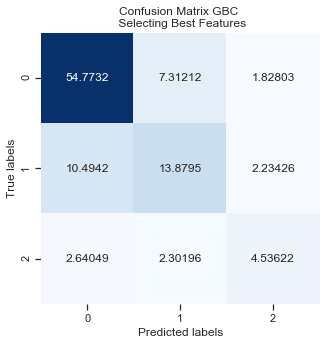

In [292]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm_porcent, annot=True, ax = ax, cmap='Blues', cbar=False, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix GBC \n Selecting Best Features'); 
ax.xaxis.set_ticklabels(['0', '1', '2']); ax.yaxis.set_ticklabels(['0', '1', '2']);
plt.show()

# Generando el modelo final

In [322]:
train = pd.read_csv('train_completo.csv')
test = pd.read_csv('test_completo.csv')

In [323]:
y = train['fault_severity']
train.drop(['id', 'fault_severity'], axis=1, inplace=True)
X = train

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [345]:
model = GradientBoostingClassifier(n_estimators=400)
model.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=400)

In [346]:
y_pred = model.predict(X_test)
y_pred_p = model.predict_proba(X_test)

In [347]:
l_loss = log_loss(y_test, y_pred_p)
print('log_loss: {}'.format(l_loss))

log_loss: 0.5662564958831399


In [348]:
cm = confusion_matrix(y_test, y_pred)
cm_porcent = 100*(cm/len(y_test))

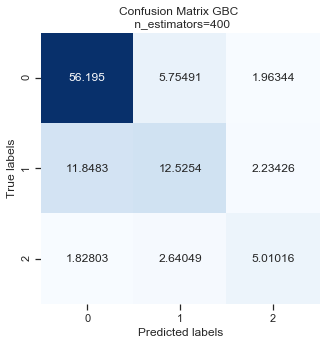

In [350]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm_porcent, annot=True, ax = ax, cmap='Blues', cbar=False, fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix GBC \n n_estimators=400'); 
ax.xaxis.set_ticklabels(['0', '1', '2']); ax.yaxis.set_ticklabels(['0', '1', '2']);
plt.show()

In [352]:
test = test.drop(columns=['id'])

In [353]:
y_sub = model.predict_proba(test)

In [354]:
test = pd.read_csv('test_completo.csv')
pred_df=pd.DataFrame(y_sub,columns=['predict_0', 'predict_1', 'predict_2'])
df_submission=pd.concat([test.id,pred_df],axis=1)
df_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0.989740,0.008696,0.001564
1,18000,0.329045,0.201813,0.469142
2,16964,0.989524,0.009246,0.001231
3,4795,0.906060,0.091273,0.002667
4,3392,0.273669,0.588372,0.137959


In [355]:
df_submission.to_csv('Third_submission.csv', index=False)